In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
from ecco_v4_py import vector_calc, scalar_calc

import gsw
import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

## Load data

In [2]:
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))

# Select a dataset (the one containing temperature and salinity)
dataset_num = 22

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num])
Vel_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]

# make a list of all of the files in the directory
Vel_dataset_files = np.sort(list(Vel_dataset_dir.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in Vel_dataset_files[:5]])

# Select a dataset (the one containing temperature and salinity)
dataset_num = 14

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num])
dens_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]

# make a list of all of the files in the directory
dens_dataset_files = np.sort(list(dens_dataset_dir.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in dens_dataset_files[:5]])

selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_VOLUME_FLUX

First 5 files
['OCEAN_VOLUME_FLUX_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-02_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-03_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-04_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-05_ECCO_V4r5_native_llc0090.nc']
selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_BOLUS_VELOCITY

First 5 files
['OCEAN_BOLUS_VELOCITY_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_BOLUS_VELOCITY_mon_mean_1992-02_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_BOLUS_VELOCITY_mon_mean_1992-03_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_BOLUS_VELOCITY_mon_mean_1992-04_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_BOLUS_VELOCITY_mon_mean_1992-05_ECCO_V4r5_native_llc0090.nc']


In [3]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:34515") #find within Scheduler Address with orange red squares)
client.ncores
client.restart()

Task exception was never retrieved
future: <Task finished name='Task-2341' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-8010' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-14982' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/pyt

In [4]:
start_time = time.time();
ds_bolus = None
ds_vel = None

files_to_load = Vel_dataset_files

print(f'lazy-loading {len(files_to_load)} granules')
# first lazy load
ds_vel = xr.open_mfdataset(Vel_dataset_files, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})
files_to_load = dens_dataset_files

print(f'lazy-loading {len(files_to_load)} granules')
# first lazy load
ds_bolus = xr.open_mfdataset(dens_dataset_files, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})


total_time = time.time() - start_time

lazy-loading 336 granules
lazy-loading 336 granules


In [5]:
geom_path = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_geom = xr.open_dataset(geom_path)

In [6]:
sig_path = '/efs_ecco/czimmerm/Sigma_2_field.nc'
ds_sig = xr.open_dataset(sig_path,\
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

In [7]:
ds_vel_clim = ds_vel.groupby("time.month").mean('time')
ds_bolus_clim = ds_bolus.groupby("time.month").mean('time')
ds_sig_clim = ds_sig.groupby("time.month").mean('time')

In [8]:
#velocities
U = ds_vel_clim.UVELMASS
u = ds_bolus_clim.UVELSTAR
V = ds_vel_clim.VVELMASS
v = ds_bolus_clim.VVELSTAR
#inputs to fxn will be utot and vtot
utot = U+u
vtot = V+v

In [9]:
#spacial
#ds_geom as an input?
dx = ds_geom.dxG
dy = ds_geom.dyG
dz = ds_geom.drF

In [43]:
#dens
#sig2 and target_levels as inputs
target_sig_levels = [28.5200, 29.4855, 30.8803, 31.6772, 32.1183, 33.2711, 34.0234, 34.5587, 35.3480, 35.7690, 36.0550, 36.2469, 36.3810, 36.4893, 36.5964, 36.7148, 36.8421, 36.9887, 37.0598, 37.1254, 37.1840, 37.2346, 37.2780, 37.3160, 37.3498, 37.3806, 37.4088, 37.4346, 37.4580, 37.4788, 37.4971, 37.5132, 37.5287, 37.5450, 37.5628, 37.5684, 37.5705, 37.5827, 37.6056, 37.6270, 37.6427, 37.6526, 37.6601, 37.7312, 37.7754, 37.8540, 37.9143, 37.9534, 37.9895, 38.0103];
sig2 = ds_sig_clim.SIG2
sig2W = sig2.rename({'i':'i_g'})
sig2S = sig2.rename({'j':'j_g'})

## atl mask

In [10]:
# pick a basin (iff statement regarding basin)
basin_name = 'atlExt'

In [11]:
maskC = ds_geom.maskC.compute()
maskS = ds_geom.maskS.compute()
maskW = ds_geom.maskW.compute()

In [22]:
#atlantic mask
atl_maskW = ecco.get_basin_mask(basin_name= basin_name,mask=maskW.isel(k=0))
atl_maskS = ecco.get_basin_mask(basin_name= basin_name,mask=maskS.isel(k=0))
atl_maskC = ecco.get_basin_mask(basin_name= basin_name,mask=maskC.isel(k=0))

get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13

In [28]:
uatl = utot*atl_maskW
vatl = vtot*atl_maskS
sigatl = sig2*atl_maskC

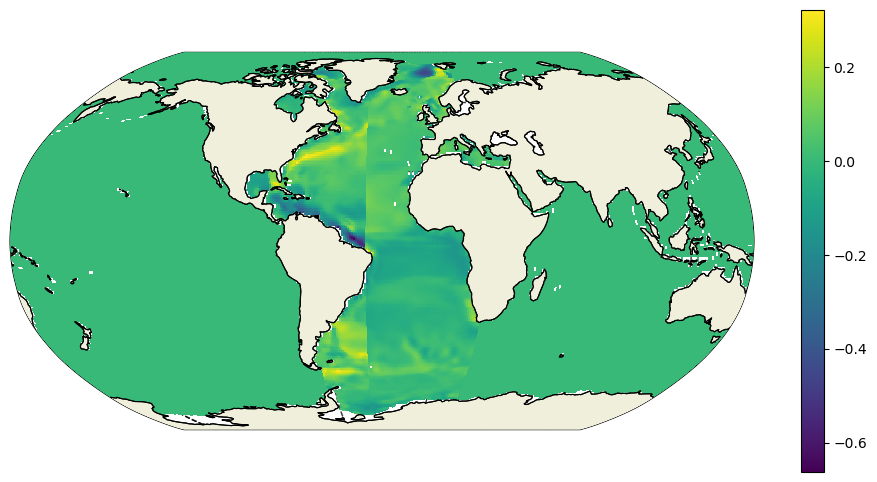

In [25]:
plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds_vel.XC,ds_vel.YC,vatl[0,0,:],
                              projection_type='robin',cmap='viridis',user_lon_0=-30,show_colorbar=True);

## calc strm

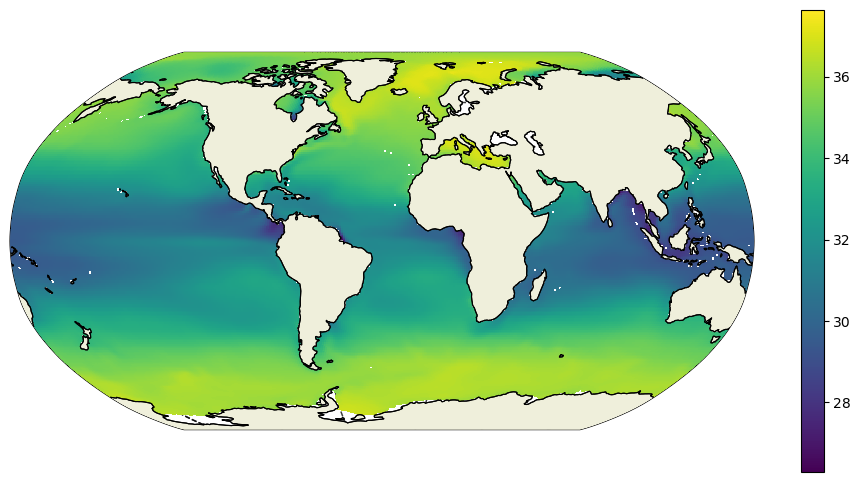

In [35]:
plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds_vel.XC,ds_vel.YC,sig2[0,0,:],
                              projection_type='robin',cmap='viridis',user_lon_0=-30,show_colorbar=True);

In [44]:
y = vtot[:,:,:]*dz[:]*dx*np.heaviside(sig2S[:,:,:]-target_sig_levels[0],1)
y.sum(dim='k')

<xarray.DataArray (month: 12, tile: 13, j_g: 90, i: 90)> Size: 10MB
dask.array<sum-aggregate, shape=(12, 13, 90, 90), dtype=float64, chunksize=(1, 13, 45, 90), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j_g, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC       (tile, j_g, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>

In [120]:
sig2S

<xarray.DataArray 'SIG2' (month: 12, k: 50, tile: 13, j_g: 90, i: 90)> Size: 505MB
dask.array<transpose, shape=(12, 50, 13, 90, 90), dtype=float64, chunksize=(12, 50, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j_g, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC       (tile, j_g, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z        (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    valid_min:              20.687723
    valid_max:              40.863277
    coverage_content_type:  modelResult
    long_name:              Salinity
    standard_name:          sea_water_salinity
    units:                  1e-3
    comment:                Defined using CF convention 'Sea water salinity i...

In [121]:
xvol = utot.copy()-utot.values
xvol = xvol.rename({'k':'sig2'}).drop_vars('Z')
yvol = vtot.copy()-vtot.values
yvol = yvol.rename({'k':'sig2'}).drop_vars('Z')
for ss in range(50):
    sig = target_sig_levels[ss]
    y = vtot*dz*dx*np.heaviside(sig2S-target_sig_levels[ss],1)
    yy = y.sum(dim='k')
    x = utot*dz*dy*np.heaviside(sig2W-target_sig_levels[ss],1)
    xx = x.sum(dim='k')
    yvol[:,ss,:] = yy
    xvol[:,ss,:] = xx

## Lat Mask

In [88]:
#pick a latitude
# Get array of 1's at and north of latitude
lat = 45
ones = xr.ones_like(ds_vel.YC)
dome_maskC = ones.where(ds_vel.YC>=lat,0).compute()

In [89]:
grid = ecco.get_llc_grid(ds_vel)
lat_maskW = grid.diff(dome_maskC,'X',boundary='fill') #multiply by x
lat_maskS = grid.diff(dome_maskC,'Y',boundary='fill') #multiply by y

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [ ]:
# exp_mask = np.abs(lat_maskW.values + lat_maskS.values)
# exp_mask = np.where(np.abs(exp_mask)>0, 1, 0)
# exp_mask_DA = ecco_ds['RHOAnoma'][0][0]*0; 
# exp_mask_DA.name = 'exp_mask'
# exp_mask_DA.values = exp_mask
# exp_mask_ins = np.where(exp_mask_DA.values.ravel() > 0)[0]
# tt_lons = ecco_ds.XC.values.ravel()[exp_mask_ins]

In [90]:
ytrsp_lat = (yvol * lat_maskS).sum(dim=['i','j_g','tile'])
xtrsp_lat = (xvol * lat_maskW).sum(dim=['i_g','j','tile'])

In [94]:
xds['psi'].loc[{'lat':lat}] = ytrsp_lat+xtrsp_lat

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 491.29 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [122]:
#set-up
ones = xr.ones_like(ds_vel.YC)
grid = ecco.get_llc_grid(ds_vel)

#lats as input to fxn
lats = np.arange(-30,80,1)
lats_da = xr.DataArray(lats,coords={'lat':lats},dims=('lat',))

xda = xr.zeros_like(yvol['sig2']*lats_da)
xda = xda.broadcast_like(yvol['month']).copy()

# Convert to dataset to add sigma2 coordinate
xds = xda.to_dataset(name='psi')
xds = xds.assign_coords({'SIGMA_levs':('sig2', target_sig_levels)})

In [ ]:
yvol=yvol.load()
xvol=xvol.load()

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 249.48 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [ ]:
for l in range(len(lats)):
    lat = lats[l]
    dome_maskC = ones.where(ds_vel.YC>=lat,0).compute()
    lat_maskW = grid.diff(dome_maskC,'X',boundary='fill') #multiply by x
    lat_maskS = grid.diff(dome_maskC,'Y',boundary='fill') #multiply by y
    ytrsp_lat = (yvol * lat_maskS).sum(dim=['i','j_g','tile'])
    xtrsp_lat = (xvol * lat_maskW).sum(dim=['i_g','j','tile'])
    xds['psi'].loc[{'lat':lat}] = ytrsp_lat+xtrsp_lat

## now play with output

In [ ]:
#xds has shape (12,110,50) == (month, lat, sig2)
#and has variable 'psi'
#and addtnl coord 'SIGMA_levs' which contains the target sigma values
#lat[0] = -30N
#lat[30] = 0 N

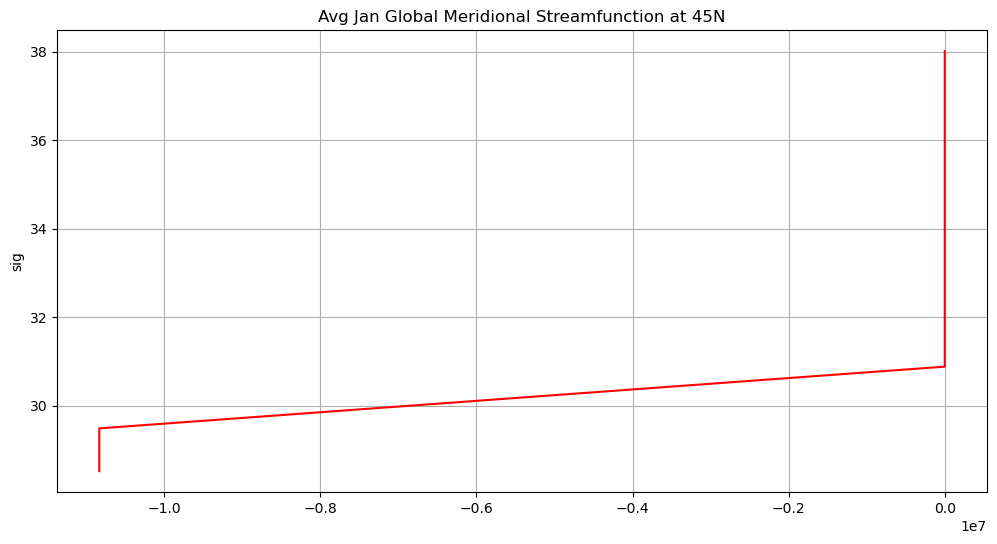

In [108]:
plt.figure(figsize=(12,6))
plt.plot(xds.psi[1,75,:],xds['SIGMA_levs'],'r')#plots january, 45N, all sig
plt.grid()
plt.title('Avg Jan Global Meridional Streamfunction at 45N')
plt.ylabel('sig')
plt.show()

In [115]:
# time mean
Psi_mean = xds['psi'].mean('month')

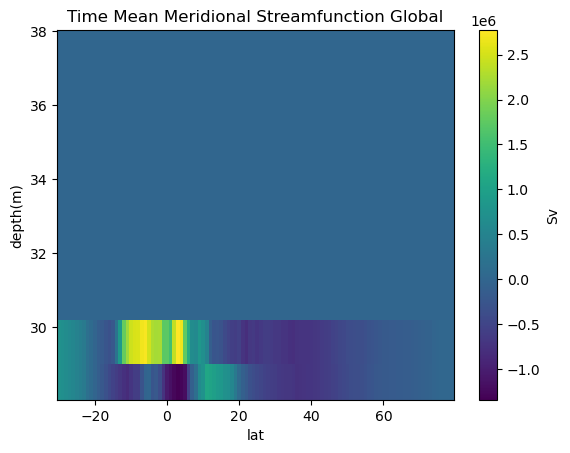

In [117]:
plt.pcolormesh(xds.lat,xds.SIGMA_levs,Psi_mean)
cb=plt.colorbar()
cb.set_label('Sv')
plt.title('Time Mean Meridional Streamfunction Global')
plt.ylabel('depth(m)')
plt.xlabel('lat')
plt.show()